In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dedispersion
import filterbankio
import seaborn as sns

%matplotlib inline

In [2]:
# watermark
lofarFil = '/home/griffin/data/lofar/block39.fil'

In [3]:
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})

### LOFAR RADAR Event

In [4]:
fil = filterbankio.Filterbank(lofarFil)
timeFactor = 64
freqFactor = 8

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [5]:
dm = 85.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [6]:
start_time = 0.0
time_window = 3.

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [7]:
# flatten bandpass
bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#waterfallNorm = waterfall - bandpass
waterfallNorm = waterfall

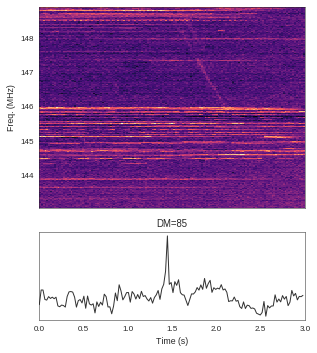

In [8]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('ARTEMIS Event (t: %i f: %i)'%(timeFactor, freqFactor))
plt.ylabel('Freq. (MHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt*timeSeries.shape[0])
#plt.title('Time Series (DM=%0.f)'%dm)
plt.title('DM=%0.f'%dm)
plt.xlabel('Time (s)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/LOFAR_dynamic.pdf')

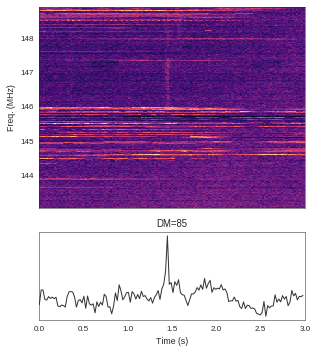

In [9]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(ddwaterfall.T), extent=(0, tInt*ddwaterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('ARTEMIS Event (t: %i f: %i)'%(timeFactor, freqFactor))
plt.ylabel('Freq. (MHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt*timeSeries.shape[0])
#plt.title('Time Series (DM=%0.f)'%dm)
plt.title('DM=%0.f'%dm)
plt.xlabel('Time (s)')
ax2.get_yaxis().set_visible(False)
#plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

### LOFAR RADAR Event (High Time)

In [10]:
fil = filterbankio.Filterbank(lofarFil)
timeFactor = 4
freqFactor = 4

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [11]:
dm = 85.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [12]:
start_time = 1.75
time_window = 0.4

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [13]:
# flatten bandpass
bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#waterfallNorm = waterfall - bandpass
waterfallNorm = waterfall

# frequency cut
f0 = 200
f1 = waterfallNorm.shape[1] - 100
waterfallNorm = waterfallNorm[:,f0:f1]
ddwaterfall = ddwaterfall[:,f0:f1]

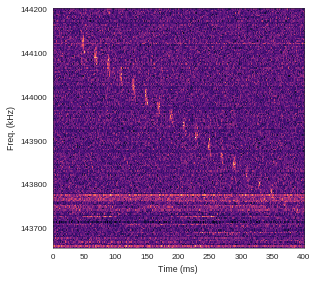

In [14]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

#fig = plt.figure(figsize=(4.5,5)) # (width, height)
fig = plt.figure(figsize=(4.5,4)) # (width, height)

#ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=3)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(waterfallNorm.T), extent=(0, tInt * waterfall.shape[0] * 1000., fil.freqs[f0] * 1000., fil.freqs[f1] * 1000.), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('ARTEMIS Event (t: %i f: %i)'%(timeFactor, freqFactor))
plt.ylabel('Freq. (kHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
#ax1.get_xaxis().set_visible(False)

#ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
##plt.subplot(2,1,2)
#lineColor = 'k'
#plt.plot(tInt*np.arange(waterfall.shape[0]), normDDTimeSeries, lineColor, alpha=0.8)
#plt.xlim(0, tInt*timeSeries.shape[0])
#plt.title('Time Series (DM=%0.f)'%dm)
plt.xlabel('Time (ms)')
#ax2.get_yaxis().set_visible(False)
##plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

plt.savefig('../figures/LOFAR_dynamic_high_res.pdf')

### LOFAR RADAR Event (High Time)

In [15]:
fil = filterbankio.Filterbank(lofarFil)
timeFactor = 4
freqFactor = 4

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [16]:
dm = 85.

ddwaterfall = dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap') # apply dedispersion

waterfall = waterfall.reshape(waterfall.shape[0], waterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
ddwaterfall = ddwaterfall.reshape(ddwaterfall.shape[0], ddwaterfall.shape[1]/freqFactor, freqFactor).sum(axis=2)
freqsHz = freqsHz[::freqFactor]

In [17]:
start_time = 1.2
time_window = 0.5

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

timeSeries = np.sum(waterfall, axis=1)
ddTimeSeries = np.sum(ddwaterfall, axis=1)

timeSeries = timeSeries[startIdx:endIdx]
ddTimeSeries = ddTimeSeries[startIdx:endIdx]
waterfall = waterfall[startIdx:endIdx,:]
ddwaterfall = ddwaterfall[startIdx:endIdx,:]

normTimeSeries = timeSeries / (waterfall.shape[1] * timeFactor)
normDDTimeSeries = ddTimeSeries / (waterfall.shape[1] * timeFactor)

In [18]:
# flatten bandpass
bandpass = np.tile(waterfall[80:].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#bandpass = np.tile(waterfall[:10].mean(axis=0).reshape(-1, 1), waterfall.shape[0]).T
#waterfallNorm = waterfall - bandpass
waterfallNorm = waterfall

# frequency cut
f0 = 200
f1 = waterfallNorm.shape[1] - 100
waterfallNorm = waterfallNorm[:,f0:f1]
ddwaterfall = ddwaterfall[:,f0:f1]

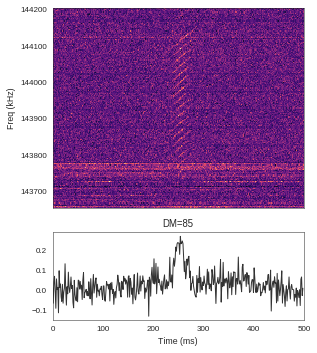

In [19]:
cmap = 'magma'
sns.set_style('white', rc={'axes.linewidth': 0.5})

fig = plt.figure(figsize=(4.5,5)) # (width, height)
#fig = plt.figure(figsize=(4.5,4)) # (width, height)

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=2)
#ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3, rowspan=3)
#plt.subplot(2,1,1)
imRaw = plt.imshow(np.flipud(ddwaterfall.T), extent=(0, tInt*ddwaterfall.shape[0], fil.freqs[f0] * 1000., fil.freqs[f1] * 1000.), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')
#imRaw = plt.imshow(np.flipud(bandpass.T), extent=(0, tInt*waterfall.shape[0], fil.freqs[0], fil.freqs[-1]), aspect='auto', cmap=plt.get_cmap(cmap), interpolation='nearest')

#plt.title('ARTEMIS Event (t: %i f: %i)'%(timeFactor, freqFactor))
plt.ylabel('Freq (kHz)')
#cax = fig.add_axes([0.75, .95, 0.15, 0.03])
#cbar = fig.colorbar(imRaw, cax=cax, orientation='horizontal')
#cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(), rotation='vertical', fontsize=8)
ax1.get_xaxis().set_visible(False)

ax2 = plt.subplot2grid((3, 3), (2, 0), colspan=3)
#plt.subplot(2,1,2)
lineColor = 'k'
plt.plot(tInt * np.arange(ddwaterfall.shape[0]) * 1000., normDDTimeSeries, lineColor, alpha=0.8)
plt.xlim(0, tInt * timeSeries.shape[0] * 1000.)
#plt.title('Time Series (DM=%0.f)'%dm)
plt.title('DM=%0.f'%dm)
plt.xlabel('Time (ms)')
#ax2.get_yaxis().set_visible(False)
##plt.ylabel('Amp')

#plt.subplots_adjust(hspace=-0.3)
plt.tight_layout()

### DM - Time

In [20]:
fil = filterbankio.Filterbank(lofarFil)
timeFactor = 32

tInt = fil.header['tsamp'] # get tInt
freqsHz = fil.freqs * 1e6 # generate array of freqs in Hz

waterfall = np.reshape(fil.data, (fil.data.shape[0], fil.data.shape[2])) # reshape to (n integrations, n freqs)

waterfall = waterfall.reshape(waterfall.shape[0]/timeFactor, timeFactor, waterfall.shape[1]).sum(axis=1)
tInt *= timeFactor

In [21]:
start_time = 0.
time_window = 3.
minDM = 0
maxDM = 320
dmStep = 1

if start_time is None:
    startIdx = 0
else:
    startIdx = int(start_time / tInt)

if time_window is None:
    endIdx = waterfall.shape[0]
else:
    endIdx = startIdx + int(time_window / tInt)
    if endIdx > waterfall.shape[0]:
        print 'Warning: time window (-w) in conjunction with start time (-s) results in a window extending beyond the filterbank file, clipping to maximum size'
        endIdx = waterfall.shape[0]

waterfall = waterfall[startIdx:endIdx,:]
testDMs = np.arange(minDM, maxDM, dmStep)

dmSpace = np.zeros((testDMs.shape[0], waterfall.shape[0]))
print dmSpace.shape
for dmid, dm in enumerate(testDMs):
    dmSpace[dmid, :] = np.sum(dedispersion.incoherent(freqsHz, waterfall, tInt, dm, boundary='wrap'), axis=1)

(320, 286)


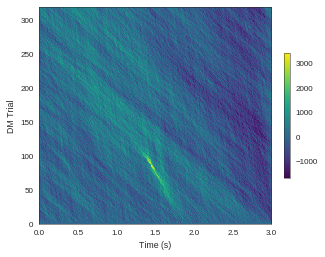

In [22]:
cmap = 'viridis'
fig = plt.figure(figsize=(4.5,4)) # (width, height)
#fig = plt.figure(figsize=(8,4)) # (width, height)

plt.imshow(np.flipud(dmSpace), aspect='auto', extent=(0, tInt*waterfall.shape[0], testDMs[0], testDMs[-1]), cmap=plt.get_cmap(cmap), interpolation='nearest')
plt.ylabel('DM Trial')
plt.xlabel('Time (s)')
plt.colorbar(fraction=0.025)
#plt.title('ARTEMIS Event')

plt.savefig('../figures/LOFAR_dm_time.pdf')